In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

%matplotlib inline  
%config InlineBackend.figure_format = 'png'
pd.options.display.max_columns = None

### Описание

Пример анализа месячного тренда падения дебита жидкости/нефти/газа <br>
Датасет скачан отсюда http://datos.minem.gob.ar/dataset/produccion-de-petroleo-y-gas-por-pozo <br>
Описание колонок здесь https://github.com/datosminem/produccion-de-petroleo-y-gas-por-pozo <br>
В датасете представлена месячная добыча (нефти, воды, газа) и закачка (воды, газа). <br>
Тренд падения аппроксимируется гиперболической формулой (hyperbolic decline) с параметрами <i>b</i> и <i>d</i>, <br>
которая описана в статье https://petrowiki.spe.org/Production_forecasting_decline_curve_analysis <br>

### Названия фактических и расчетных столбцов

In [2]:
# Столбцы даты
# Должен быть указан столбец с датами либо пара столбцов Год-Месяц
DATE = ""               # отчетная дата
YEAR = "anio"           # год
MONTH = "mes"           # месяц

# Столбцы из датасета
WELL = "idpozo"      # идентификатор скважины или перфорации
DAYS = "tef"         # количество рабочих дней
OIL = "prod_pet"     # добыча нефти
GAS = "prod_gas"     # добыча газа
WATER = "prod_agua"  # добыча воды

# Расчетные столбцы
LIQ = "LIQ"                            # жидкость
WCOUNT = "WELLCOUNT"                   # кол-во скважин
MONTH_FROM_START = "MONTH_FROM_START"  # номер месяца от начала добычи по скважине
RATE = "RATE"                          # дебит
DECLINE = "DECLINE"                    # темп падения
CUMPROD = "CUMPROD"                    # накопленная добыча

### Настройка столбца дебита и периода расчета тренда

In [3]:
# Выбор столбца добычи (жидкости/нефти/газа), для которого будет рассчитан темп падения дебита
PROD = GAS

In [4]:
# Количество месяцев для расчета тренда падения
month_cnt = 50

### Настройка фильтров (при необходимости)

In [5]:
# Первое значение - имя столбца, второе значение - значение фильтра по данному столбцу
filter_dict = { "areayacimiento" : "GUANACO", "formacion" : "precuyo", "tipopozo" : "Gasífero" }
# Если фильтр не нужен, нужно раскомментировать следующую строчку
# filter_dict = dict() 

### Чтение данных

In [6]:
csvfilename = "produccin-de-pozos-de-gas-y-petrleo-no-convencional.csv"

In [7]:
df = pd.read_csv(csvfilename, header=0)
df.rename(columns=str.strip, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113221 entries, 0 to 113220
Data columns (total 40 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   idempresa               113221 non-null  object 
 1   anio                    113221 non-null  int64  
 2   mes                     113221 non-null  int64  
 3   idpozo                  113221 non-null  int64  
 4   prod_pet                113221 non-null  float64
 5   prod_gas                113221 non-null  float64
 6   prod_agua               113221 non-null  float64
 7   iny_agua                113221 non-null  float64
 8   iny_gas                 113221 non-null  float64
 9   iny_co2                 113221 non-null  float64
 10  iny_otro                113221 non-null  float64
 11  tef                     113221 non-null  float64
 12  vida_util               2836 non-null    float64
 13  tipoextraccion          112847 non-null  object 
 14  tipoestado          

In [8]:
df.head(5)

,idempresa,anio,mes,idpozo,prod_pet,prod_gas,prod_agua,iny_agua,iny_gas,iny_co2,iny_otro,tef,vida_util,tipoextraccion,tipoestado,tipopozo,observaciones,fechaingreso,rectificado,habilitado,idusuario,empresa,sigla,formprod,profundidad,formacion,idareapermisoconcesion,areapermisoconcesion,idareayacimiento,areayacimiento,cuenca,provincia,coordenadax,coordenaday,tipo_de_recurso,proyecto,clasificacion,subclasificacion,sub_tipo_recurso,fecha_data
0,YSUR,2015,1,133430,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,NaN,Sin Sistema de Extracción,En Estudio,Gasífero,NaN,2015-02-26 13:35:35.533458,f,t,5,YSUR ENERGÍA ARGENTINA S.R.L.,AEA.NQ.RCo.x-2001,PREC,3204.0,precuyo,SDD,AL SUR DE LA DORSAL,RQC,RANQUIL CO,NEUQUINA,Neuquén,-69.193993,-39.078224,NO CONVENCIONAL,GAS PLUS,EXPLORACION,EXPLORACION,TIGHT,2015-01-31
1,YSUR,2015,1,152786,242.14,2195.54,49.30,0.0,0.0,0.0,0.0,31.0,NaN,Surgencia Natural,Extracción Efectiva,Gasífero,NaN,2015-02-26 13:35:35.533458,f,t,5,YSUR ENERGÍA ARGENTINA S.R.L.,APA.Nq.Rco-1054,PREC,2940.0,precuyo,SDD,AL SUR DE LA DORSAL,RQC,RANQUIL CO,NEUQUINA,Neuquén,-69.181060,-39.079080,NO CONVENCIONAL,GAS PLUS,EXPLOTACION,DESARROLLO,TIGHT,2015-01-31
2,YSUR,2015,1,147505,8.52,153.82,14.71,0.0,0.0,0.0,0.0,31.0,NaN,Plunger Lift,Extracción Efectiva,Gasífero,NaN,2015-02-26 13:35:35.533458,f,t,5,YSUR ENERGÍA ARGENTINA S.R.L.,APA.Nq.RCo-1053(d),PREC,2852.0,precuyo,SDD,AL SUR DE LA DORSAL,RQC,RANQUIL CO,NEUQUINA,Neuquén,-69.181060,-39.079080,NO CONVENCIONAL,GAS PLUS,EXPLOTACION,DESARROLLO,TIGHT,2015-01-31
3,YSUR,2015,1,136856,15.14,359.21,20.00,0.0,0.0,0.0,0.0,31.0,NaN,Plunger Lift,Extracción Efectiva,Gasífero,NaN,2015-02-26 13:35:35.533458,f,t,5,YSUR ENERGÍA ARGENTINA S.R.L.,APA.Nq.RCo-1052(d),PREC,2801.0,precuyo,SDD,AL SUR DE LA DORSAL,RQC,RANQUIL CO,NEUQUINA,Neuquén,-69.183183,-39.083081,NO CONVENCIONAL,GAS PLUS,EXPLOTACION,DESARROLLO,TIGHT,2015-01-31
4,YSUR,2015,1,153660,9.62,0.00,18.59,0.0,0.0,0.0,0.0,2.0,NaN,Surgencia Natural,Extracción Efectiva,Gasífero,NaN,2015-02-26 13:35:35.533458,f,t,5,YSUR ENERGÍA ARGENTINA S.R.L.,APA.Nq.RCo-1046(d),PREC,3000.0,precuyo,SDD,AL SUR DE LA DORSAL,RQC,RANQUIL CO,NEUQUINA,Neuquén,-69.174582,-39.075801,NO CONVENCIONAL,GAS PLUS,EXPLOTACION,DESARROLLO,TIGHT,2015-01-31


In [9]:
# Список провинций
np.sort(df["provincia"].unique().astype(str))

array(['Chubut', 'Mendoza', 'Neuquén', 'Rio Negro', 'Salta', 'Santa Cruz'],
      dtype='<U10')

In [10]:
# Список месторождений
np.sort(df["empresa"].unique().astype(str))

array(['AMERICAS PETROGAS ARGENTINA S.A.',
       'APACHE ENERGIA ARGENTINA S.R.L.',
       'APCO OIL AND GAS INTERNATIONAL INC (SUCURSAL ARGENTINA)',
       'ARGENTA ENERGIA S.A.', 'CAPEX S.A.', 'CHEVRON ARGENTINA S.R.L.',
       'COMPAÑÍA GENERAL DE COMBUSTIBLES S.A.', 'ENERGICON S.A.',
       'EXXONMOBIL EXPLORATION ARGENTINA S.R.L.',
       'GAS Y PETROLEO DEL NEUQUEN S.A.', 'GRECOIL y CIA. S.R.L.',
       'KILWER S.A.', 'MADALENA AUSTRAL S.A.',
       'MADALENA ENERGY ARGENTINA SRL ', 'MEDANITO S.A.',
       'O&G DEVELOPMENTS LTD S.A.', 'OILSTONE ENERGIA S.A.',
       'PAMPA ENERGIA S.A.',
       'PAN AMERICAN ENERGY (SUCURSAL ARGENTINA) LLC',
       'PETROBRAS ARGENTINA S.A.', 'PETROLERA EL TREBOL S.A.',
       'PETROLERA ENTRE LOMAS S.A.', 'PLUSPETROL S.A.',
       'PRESIDENT PETROLEUM S.A.', 'ROCH S.A.', 'TECPETROL S.A.',
       'TOTAL AUSTRAL S.A.', 'Vista Oil & Gas Argentina SA',
       'WINTERSHALL ENERGIA S.A.', 'YPF S.A.',
       'YSUR ENERGÍA ARGENTINA S.R.L.'], dtype='<U

In [11]:
# Список пластов
np.sort(df["formacion"].unique().astype(str))

array(['agrio', 'basamento', 'centenario', 'chachao',
       'formación improductiva', 'grupo chubut', 'lajas', 'loma montosa',
       'los molles', 'lotena', 'magallanes', 'mulichinco', 'precuyo',
       'punta rosada', 'quintuco', 'sierras blancas', 'tordillo',
       'vaca muerta', 'yacoraite'], dtype='<U22')

In [12]:
# Список типов скважин
np.sort(df["tipopozo"].unique().astype(str))

array(['Gasífero', 'Inyección de Agua', 'Inyección de Gas', 'Otro tipo',
       'Petrolífero', 'Sumidero', 'nan'], dtype='<U17')

### Расчет дополнительных столбцов

In [13]:
if len(DATE) > 0:
# столбцы Год и Месяц рассчитываются при указании столбца дат
    YEAR = "YEAR"
    MONTH = "MONTH"
    df[DATE] = pd.to_datetime(df[DATE])
    df[MONTH] = pd.DatetimeIndex(df[DATE]).month 
    df[YEAR] = pd.DatetimeIndex(df[DATE]).year
else:
# столбец Дата рассчитывается при указании пары столбцов Год-Месяц
    DATE = "DATE"
    df[DATE] = pd.to_datetime(df[YEAR] * 10000 + df[MONTH] * 100 + 1, format='%Y%m%d')
    
# расчет столбца Добыча жидкости
df[LIQ] = df[OIL] + df[WATER]

### Визуализация графика дебита по скважинам

In [14]:
# Для расчета создается отдельный объект с нужными столбцами с учетом заданного фильтра
well_month_prod = df.loc[(df[filter_dict.keys()] == pd.Series(filter_dict)).all(axis=1), 
                         [WELL, DATE, YEAR, MONTH, DAYS, PROD]]

In [15]:
# Расчет дебита для графика
well_month_prod[RATE] = 0.0
well_month_prod.loc[(well_month_prod[DAYS] > 0), RATE] = well_month_prod[PROD] / well_month_prod[DAYS]

In [16]:
well_month_prod.head(5)

,idpozo,DATE,anio,mes,tef,prod_gas,RATE
24,136137,2015-01-01,2015,1,31.0,494.57,15.953871
26,153208,2015-01-01,2015,1,26.0,199.25,7.663462
27,133429,2015-01-01,2015,1,31.0,1029.64,33.214194
28,132604,2015-01-01,2015,1,31.0,172.28,5.557419
29,132879,2015-01-01,2015,1,31.0,303.32,9.784516


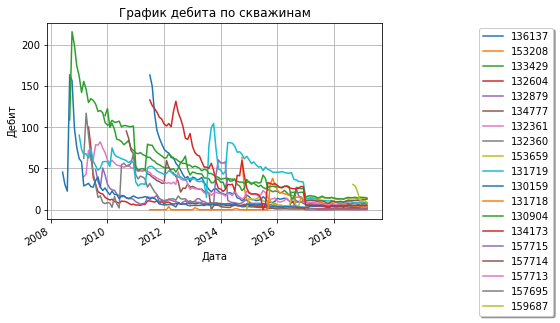

In [17]:
# Построение графика
fig, ax = plt.subplots()

wells = list(well_month_prod[WELL].unique())
for name in wells:
    df_plot = well_month_prod.loc[well_month_prod[WELL] == name, :]
    df_plot.plot(x=DATE, y=RATE, label=name, ax=ax)
    
plt.legend(loc='upper center', bbox_to_anchor=(1.4, 1), shadow=True, ncol=1)
ax.set_xlabel("Дата")
ax.set_ylabel("Дебит")
plt.title("График дебита по скважинам")
plt.grid(True)
plt.show()

### Приведение добычи по скважинам к единой дате

In [18]:
# Расчет столбца сквозной нумерации месяцев от начала добычи
min_date = well_month_prod[DATE].min()
min_month = min_date.month
min_year = min_date.year
well_month_prod[MONTH_FROM_START] = (well_month_prod[YEAR] - min_year) * 12 + well_month_prod[MONTH] - min_month

In [19]:
# Расчет месяца начала добычи по скважинам (месяцем начала из сквозной нумерации считается номер месяца от начала добычи 
# с первым ненулевым значением рабочих дней)
# Для этого рассчитывается сводная таблица минимальных значений сквозного месяца с группировкой по скважинам.
# Результатом является таблица "Скважина : Номер месяца начала добычи" в виде словаря.
well_start_dict = well_month_prod.loc[well_month_prod[DAYS] > 0, :].groupby([WELL]).agg({ MONTH_FROM_START: 'min' }).to_dict()
well_start_dict = well_start_dict[MONTH_FROM_START]
well_start_dict

{130159: 0,
 130904: 3,
 131718: 45,
 131719: 7,
 132360: 9,
 132361: 9,
 132604: 11,
 132879: 14,
 133429: 18,
 134173: 37,
 134777: 27,
 136137: 37,
 153208: 76,
 153659: 79,
 157695: 103,
 157713: 103,
 157714: 103,
 157715: 103,
 159687: 123}

In [20]:
# Получаем список скважин для цикла
wells = list(well_start_dict.keys())
# В цикле по каждой скважине рассчитывается (точнее пересчитывается) столбец месяца от начала добычи.
# В результате в данном столбце получается сквозная нумерация месяца, идущая от начала добычи каждой скважины.
for well in wells:
    well_month_prod.loc[(well_month_prod[WELL] == well), MONTH_FROM_START] = \
    well_month_prod.loc[(well_month_prod[WELL] == well), MONTH_FROM_START] - well_start_dict[well]

In [21]:
well_month_prod = well_month_prod[well_month_prod[MONTH_FROM_START] >= 0]

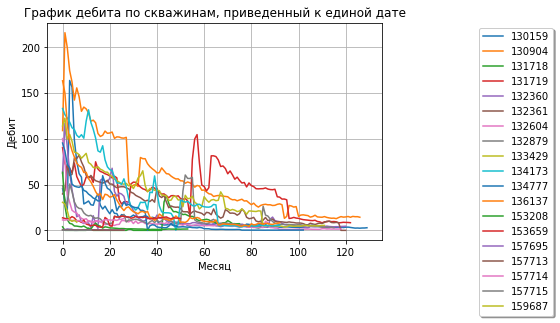

In [22]:
# Построение графика
fig, ax = plt.subplots()

for name in wells:
    df_plot = well_month_prod.loc[well_month_prod[WELL] == name, :].sort_values(by=[MONTH_FROM_START])
    df_plot.plot(x=MONTH_FROM_START, y=RATE, label=name, ax=ax)
    
plt.legend(loc='upper center', bbox_to_anchor=(1.4, 1), shadow=True, ncol=1)
ax.set_xlabel("Месяц")
ax.set_ylabel("Дебит")
plt.title("График дебита по скважинам, приведенный к единой дате")
plt.grid(True)
plt.show()

### Расчет темпа падения усредненного дебита

In [23]:
# Расчет суммы рабочих дней и добычи по всем скважинам для каждого сквозного месяца
decline_df = well_month_prod.loc[(well_month_prod[DAYS] > 0), :].groupby([MONTH_FROM_START]).agg(
    { 
        WELL:  'nunique',
        DAYS:  'sum',
        PROD:  'sum'
    }
)

In [24]:
# Сброс индекса и переименование колонок
decline_df = decline_df.reset_index()
decline_df.columns = [MONTH_FROM_START, WCOUNT, DAYS, PROD]
decline_df.sort_values(by=[MONTH_FROM_START], inplace=True)

In [25]:
# Расчет усредненного дебита 
decline_df[RATE] = 0.0
decline_df.loc[(decline_df[DAYS] > 0), RATE] = decline_df[PROD] / decline_df[DAYS]

In [26]:
# Расчет показателя падения дебита жидкости и нефти
max_rate_index = decline_df[RATE].idxmax(axis=1)
decline_df[DECLINE] = decline_df[RATE] / decline_df.loc[max_rate_index, RATE]

In [27]:
# Темп падения будет рассчитан начиная от месяца, в котором дебит имеет максимальное значение
min_decl_month = decline_df.loc[max_rate_index, MONTH_FROM_START]   # номер месяца начала расчета
max_decl_month = min_decl_month + month_cnt                         # номер месяца конца расчета

In [28]:
decline_df.head(5)

,MONTH_FROM_START,WELLCOUNT,tef,prod_gas,RATE,DECLINE
0,0,19,369.13,18776.890,50.867960,0.748726
1,1,18,507.13,34454.105,67.939394,1.000000
2,2,18,510.90,28721.567,56.217591,0.827467
3,3,18,486.84,27073.862,55.611416,0.818544
4,4,18,511.10,27542.167,53.888020,0.793178


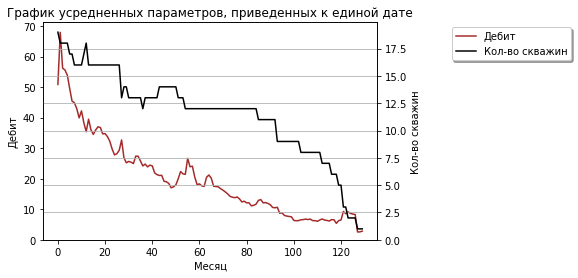

In [29]:
# Построение графика
fig, ax1 = plt.subplots()
ax1.set_xlabel("Месяц")

l1, = ax1.plot(decline_df[MONTH_FROM_START], decline_df[RATE], color='brown', label="Дебит")
ax1.set_ylim(0)
ax1.set_ylabel("Дебит")

ax2 = ax1.twinx()
l2, = ax2.plot(decline_df[MONTH_FROM_START], decline_df[WCOUNT], color='black', label="Кол-во скважин")
ax2.set_ylim(0)
ax2.set_ylabel("Кол-во скважин")

plt.legend(handles=(l1, l2), loc='upper center', bbox_to_anchor=(1.4, 1), shadow=True, ncol=1)
plt.title("График усредненных параметров, приведенных к единой дате")
plt.grid(True)
plt.show()

In [30]:
# Обобщенная функция темпа падения
def decline_func(x, b, d):
    return 1 / ((1 + b * d * x) ** (1 / b))

In [31]:
# Подготовка массивов времени и темпа падения для решения задачи оптимизации
xdata = decline_df.loc[(decline_df[MONTH_FROM_START] >= min_decl_month) & 
                       (decline_df[MONTH_FROM_START] <= max_decl_month), MONTH_FROM_START] - min_decl_month
ydata = decline_df.loc[(decline_df[MONTH_FROM_START] >= min_decl_month) & 
                       (decline_df[MONTH_FROM_START] <= max_decl_month), DECLINE]

In [32]:
# Вызов справки по функции curve_fit()
#?curve_fit

In [33]:
# Вызов функции подбора параметров функции падения
# bounds ограничивают область значений параметров функции падения.
popt, pcov = curve_fit(decline_func, xdata, ydata, p0=[1, 1], bounds=([1e-6, 1e-6], [10, 10]), 
                       method='dogbox', max_nfev=1000)

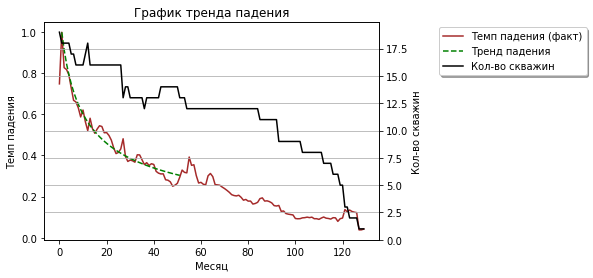

In [34]:
# Построение графика
fig, ax1 = plt.subplots()
ax1.set_xlabel("Месяц")

l1, = ax1.plot(decline_df[MONTH_FROM_START], decline_df[DECLINE], 
               color='brown', label="Темп падения (факт)")
l2, = ax1.plot(np.linspace(0, max_decl_month - min_decl_month) + min_decl_month, 
               decline_func(np.linspace(0, max_decl_month - min_decl_month), *popt), 
               color='green', linestyle='--', label="Тренд падения")
#ax1.set_ylim(0, 1)
ax1.set_ylabel("Темп падения")

ax2 = ax1.twinx()
l3, = ax2.plot(decline_df[MONTH_FROM_START], decline_df[WCOUNT], color='black', label="Кол-во скважин")
ax2.set_ylim(0)
ax2.set_ylabel("Кол-во скважин")

plt.legend(handles=(l1, l2, l3), loc='upper center', bbox_to_anchor=(1.4, 1), shadow=True, ncol=1)
plt.title("График тренда падения")
plt.grid(True)
plt.show()

In [35]:
# Значения оптимальных параметров функции падения, полученные в результате подбора
print("Номер месяца, соответствующего максимальному дебиту:", min_decl_month)
print("Параметр b:", popt[0])
print("Параметр d:", popt[1])

Номер месяца, соответствующего максимальному дебиту: 1
Параметр b: 1.9868170275027999
Параметр d: 0.09765497849835622
